![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Aprendizaje por transferencia

En este notebook usará  modelos previamente entrenados para la detección de rostros y la predicción de edad y genero, es decir usará aprendizaje por transferencia o *transfer learning*.

## Instrucciones Generales

Este notebook usará inicialmente la librería [MTCNN](https://github.com/ipazc/mtcnn) para detectar rostros en una imagen, y posteriormente reutilizará el modelo VGGFace para predecir la edad y el genero de los rostros. En el siguente paper puede conocer más detalles del modelo VGGFace: *Qawaqneh, Z., Mallouh, A. A., & Barkana, B. D. (2017). Deep convolutional neural network for age estimation based on VGG-face model. arXiv preprint arXiv:1709.01664.*. https://arxiv.org/abs/1709.01664
  
Para realizar la actividad, solo siga las indicaciones asociadas a cada celda del notebook. 

## Importar imagenes y librerías

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación librerías
from matplotlib import pyplot as plt
import numpy as np
import urllib.request
from PIL import Image
import requests

In [3]:
import os
os.chdir('..')

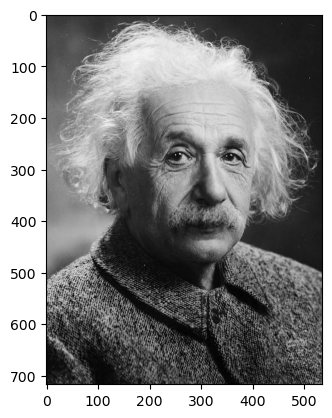

In [4]:
filename = ("https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/face_1.jpeg")
image = Image.open(urllib.request.urlopen(filename))
plt.imshow(image)

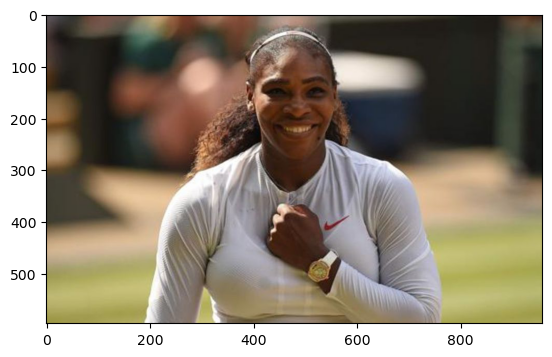

In [5]:
filename = "https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/face_2.jpeg"
image = Image.open(urllib.request.urlopen(filename))
plt.imshow(image)

## Extraer rostro de una imagen

Para ejecutar esta sección del código debe instalar la librería MTCNN con el comando *!pip install mtcnn*

In [11]:
# Importación detector de rostros
from mtcnn.mtcnn import MTCNN

# Definición detector de rostros
detector = MTCNN()
results = detector.detect_faces(image)
results

ModuleNotFoundError: No module named 'cv2'

In [ ]:
# Función para extraer rostros
def get_face(img):
    # Carga de imagen
    pixels = plt.imread(img, format='jpeg')
    results = detector.detect_faces(pixels)
    # Extracción del rosto
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    # Reescalar imagen a tamaño específico
    required_size=(224, 224)
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    # Retornar rostro
    return face_array

In [ ]:
img1 = get_face("https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/face_1.jpeg")
pyplot.imshow(img1)

In [ ]:
img2 = get_face("https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/face_2.jpeg")
pyplot.imshow(img2)

## Generar embbeding (vector) para cada rostro

Para ejecutar esta sección del código deben instalar la siguiente librería *!pip install keras_vggface*

In [ ]:
from keras_vggface.vggface import VGGFace
import numpy as np

Si al instalar la librería sigue presentando algun error al cargarla, por favor correr el siguiente código en una celda adicional.
<code>
import sys
path = '\\'.join(sys.executable.split('\\')[:-1])
filename = path + "\\lib\\site-packages\\keras_vggface\\models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))
</code>

In [ ]:
# Definición modelo vggface
model = VGGFace(model='resnet50')

# impresión de tamaño de inputs y outputs
print('Inputs: %s' % model.inputs)
print('Outputs: %s' % model.outputs)

In [ ]:
# Predicción embedding del modelo para rostro 1
yhat1 = model.predict(img1[np.newaxis,:,:,:])
print(yhat1.shape)
yhat1

In [ ]:
# Predicción embedding del modelo para rostro 2
yhat2 = model.predict(img2[np.newaxis,:,:,:])
print(yhat2.shape)
yhat2

## Predecir genero y edad

Para ejecutar esta sección del código debe instalar la librería omegaconf con el comando *!pip install omegaconf*. Adicionalmente, debe descargar un archivo tipo '.hdf5' donde se encuentran los pesos calibrados del modelo preentrenado, esto se realiza con el código de la siguiente celda. 

In [ ]:
import requests

# Definir dirección URL donde se encuentra el archivo 
remote_url = 'https://github.com/yu4u/age-gender-estimation/releases/download/v0.6/EfficientNetB3_224_weights.11-3.44.hdf5'
# Definir nombre del archivo
local_file = 'datasets/EfficientNetB3_224_weights.11-3.44.hdf5'
# Hacer requerimiento con la función request.get() y guardar archivo
data = requests.get(remote_url)
with open(local_file, 'wb')as file:
    file.write(data.content)

In [ ]:
# Importación librerías
from tensorflow.keras import applications
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from omegaconf import OmegaConf
from pathlib import Path

WEIGHTS_FILE = 'datasets/EfficientNetB3_224_weights.11-3.44.hdf5'
model_name, img_size = Path(WEIGHTS_FILE).stem.split("_")[:2]
cfg = OmegaConf.from_dotlist([f"model.model_name={model_name}", f"model.img_size={img_size}"])

In [ ]:
# Definición modelo
def get_model(cfg):
    base_model = getattr(applications, cfg.model.model_name)(
        include_top=False,
        input_shape=(cfg.model.img_size, cfg.model.img_size, 3),
        pooling="avg"
    )
    features = base_model.output
    # Capa adicional para predicción de genero
    pred_gender = Dense(units=2, activation="softmax", name="pred_gender")(features)
    # Capa adicional para predicción de edad
    pred_age = Dense(units=101, activation="softmax", name="pred_age")(features)
    model = Model(inputs=base_model.input, outputs=[pred_gender, pred_age])
    return model

In [ ]:
# Cargar modelo con set de parámetros
model = get_model(cfg)
model.load_weights(WEIGHTS_FILE)

In [ ]:
# Predicciónes del modelo imagen 1
results = model.predict(img1[np.newaxis,:,:,:])

In [ ]:
# Predicciones imagen 1
ages = np.arange(0, 101).reshape(101, 1)
predicted_ages = results[1].dot(ages).flatten()
predicted_genere = 'hombre' if (results[0][0][1] >= 0.5) else 'mujer'

print('Edad imagen 1: ', predicted_ages)
print('Genero imagen 1: ', predicted_genere)

In [ ]:
# Predicciónes del modelo imagen 2
results = model.predict(img2[np.newaxis,:,:,:])

In [ ]:
# Predicciones imagen 2
ages = np.arange(0, 101).reshape(101, 1)
predicted_ages = results[1].dot(ages).flatten()
predicted_genere = 'hombre' if (results[0][0][1] >= 0.5) else 'mujer'

print('Edad imagen 2: ', predicted_ages)
print('Genero imagen 2: ', predicted_genere)